# Block 0 — Imports (environment + tooling)

What this block does:
Sets up everything you need for the notebook:

Core Python utilities (os, re, typing, dataclasses) so later functions are clean and reusable.

Data tools (numpy, pandas) for EDA and transformations.

Model-prep tools from scikit-learn (pipelines, imputers, one-hot encoding, group CV, class weights) so your EDA can directly flow into modeling without rewriting everything later.

In [1]:
import os
import re
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Block 1 — Load stats.csv from Kaggle automatically

What this block does:
Downloads the dataset from Kaggle on demand (no CSV upload to GitHub needed), then reads only stats.csv into a DataFrame.
This makes your GitHub project clean and reproducible: anyone can run your notebook and get the same raw input as long as they can authenticate with Kaggle.

In [2]:
from pathlib import Path
import pandas as pd
import kagglehub

def load_stats_only() -> pd.DataFrame:
    ds_dir = Path(kagglehub.dataset_download("stoney71/aflstats"))
    stats_path = ds_dir / "stats.csv"
    return pd.read_csv(stats_path)

stats = load_stats_only()

# Block 2 — Standardize column names

What this block does:
Cleans column names into a consistent format so downstream code is less error-prone.
Specifically:

trims spaces

replaces spaces/symbols with _

collapses repeated underscores
This prevents annoying issues like "Player Name" vs "PlayerName" or hidden spaces in headers.

In [3]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    def _clean(c: str) -> str:
        c = c.strip()
        c = re.sub(r"[^\w]+", "_", c)
        c = re.sub(r"__+", "_", c)
        return c.strip("_")

    df = df.copy()
    df.columns = [_clean(c) for c in df.columns]
    return df

# Block 3 — Schema overview printer

What this block does:
Prints a full “health check” snapshot of the dataframe to confirm:

- shape (rows × cols)
- column names
- dtypes (what’s numeric vs text)
- a small preview of rows

In [4]:
def schema_overview(df, name="DATAFRAME", n=5):
    print("\n" + "=" * 80, flush=True)
    print(f"{name} — shape={df.shape}", flush=True)
    print("=" * 80, flush=True)
    print("Columns:", list(df.columns), flush=True)
    print("\nDtypes:\n", df.dtypes.sort_values(), flush=True)
    print("\nHead:\n", df.head(n), flush=True)

schema_overview(stats, "STATS (raw)")


STATS (raw) — shape=(128938, 31)
Columns: ['GameId', 'Year', 'Round', 'Team', 'PlayerId', 'PlayerName', 'GameNumber', 'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'HitOuts', 'Tackles', 'Rebounds', 'Inside50s', 'Clearances', 'Clangers', 'Frees', 'FreesAgainst', 'BrownlowVotes', 'ContestedPossessions', 'UncontestedPossessions', 'ContestedMarks', 'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists', '%Played', 'Subs']

Dtypes:
 Rebounds                   int64
UncontestedPossessions     int64
ContestedPossessions       int64
BrownlowVotes              int64
FreesAgainst               int64
Frees                      int64
Clangers                   int64
Clearances                 int64
Inside50s                  int64
%Played                    int64
Tackles                    int64
HitOuts                    int64
Behinds                    int64
Goals                      int64
Handballs                  int64
Marks                      int64
Kicks            

# Block 4 — Apply column cleaning + confirm it worked

Shows the first few column names before/after standardization, then prints the full schema.

In [5]:
print("before:", list(stats.columns)[:10])
stats = standardize_columns(stats)
print("after:", list(stats.columns)[:10])

schema_overview(stats, "STATS (typed)")

before: ['GameId', 'Year', 'Round', 'Team', 'PlayerId', 'PlayerName', 'GameNumber', 'Disposals', 'Kicks', 'Marks']
after: ['GameId', 'Year', 'Round', 'Team', 'PlayerId', 'PlayerName', 'GameNumber', 'Disposals', 'Kicks', 'Marks']

STATS (typed) — shape=(128938, 31)
Columns: ['GameId', 'Year', 'Round', 'Team', 'PlayerId', 'PlayerName', 'GameNumber', 'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'HitOuts', 'Tackles', 'Rebounds', 'Inside50s', 'Clearances', 'Clangers', 'Frees', 'FreesAgainst', 'BrownlowVotes', 'ContestedPossessions', 'UncontestedPossessions', 'ContestedMarks', 'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists', 'Played', 'Subs']

Dtypes:
 Rebounds                   int64
UncontestedPossessions     int64
ContestedPossessions       int64
BrownlowVotes              int64
FreesAgainst               int64
Frees                      int64
Clangers                   int64
Clearances                 int64
Inside50s                  int64
Played            

# Block 5 — Stats-only EDA checks (grain, missingness, duplicates, structure, sanity)

Defines the core EDA checks you need before modeling:

- confirms required columns exist
- reports missingness
- checks duplicates at the expected grain (GameId, Team, PlayerId)
- checks each game has ~2 teams and realistic player counts
- quick sanity checks (disposals identity, negative counts, Played distribution)

In [6]:
def stats_key_checks(stats: pd.DataFrame) -> None:
    required = ["GameId", "Year", "Round", "Team", "PlayerId"]
    missing = [c for c in required if c not in stats.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    print("Rows:", len(stats))
    print("Unique GameId:", stats["GameId"].nunique())
    print("Unique PlayerId:", stats["PlayerId"].nunique())
    print("Unique Team:", stats["Team"].nunique())
    print("Years:", sorted(stats["Year"].dropna().unique())[:5], "...")


def stats_missingness(stats: pd.DataFrame, top_n: int = 20) -> None:
    miss = stats.isna().mean().sort_values(ascending=False).head(top_n)
    print("Top missing columns:\n", miss)


def stats_duplicate_checks(stats: pd.DataFrame) -> None:
    print("Exact duplicate rows:", int(stats.duplicated().sum()))

    key = ["GameId", "Team", "PlayerId"]
    dup_key = stats.duplicated(subset=key).sum()
    print(f"Duplicates on {key}:", int(dup_key))
    if dup_key > 0:
        print(stats.loc[stats.duplicated(subset=key, keep=False)].sort_values(key).head(20))


def stats_game_structure_checks(stats: pd.DataFrame) -> None:
    teams_per_game = stats.groupby("GameId")["Team"].nunique()
    print("\nTeams per game (value counts):\n", teams_per_game.value_counts().sort_index())

    players_per_team_game = stats.groupby(["GameId", "Team"])["PlayerId"].nunique()
    print("\nPlayers per (GameId, Team) summary:\n", players_per_team_game.describe(percentiles=[.01,.05,.5,.95,.99]))

    weird_games = teams_per_game[teams_per_game != 2]
    if len(weird_games) > 0:
        print("\nWeird GameIds (teams != 2) sample:\n", weird_games.head(20))


def stats_sanity_checks(stats: pd.DataFrame) -> None:
    if all(c in stats.columns for c in ["Disposals", "Kicks", "Handballs"]):
        mismatch = (stats["Disposals"] != (stats["Kicks"] + stats["Handballs"])).mean()
        print("Disposals != Kicks+Handballs rate:", float(mismatch))

    core = [c for c in ["Goals","Behinds","Kicks","Handballs","Marks","Tackles"] if c in stats.columns]
    for c in core:
        neg = (stats[c] < 0).sum()
        if neg:
            print(f"NEGATIVE values found in {c}: {int(neg)}")

    if "Played" in stats.columns:
        print("\nPlayed summary:\n", stats["Played"].describe(percentiles=[.01,.05,.5,.95,.99]))

# Block 6 — Build team-game targets (points + win/loss) from stats only

Creates a team-game table by summing player goals/behinds into team points, pairing opponents within each GameId, then computing margin + win label.

In [7]:
def build_team_game_targets_from_stats(stats: pd.DataFrame) -> pd.DataFrame:
    if not all(c in stats.columns for c in ["Goals", "Behinds"]):
        raise ValueError("Need Goals and Behinds columns to build team points.")

    df = stats.copy()
    df["player_points"] = 6 * df["Goals"].fillna(0) + df["Behinds"].fillna(0)

    team_game = (
        df.groupby(["GameId", "Year", "Team"], as_index=False)
          .agg(team_points=("player_points", "sum"),
               n_players=("PlayerId", "nunique"))
    )

    opp = team_game.rename(columns={"Team": "OppTeam", "team_points": "opp_points"})[["GameId", "OppTeam", "opp_points"]]
    tg = team_game.merge(opp, on="GameId", how="left")
    tg = tg[tg["Team"] != tg["OppTeam"]]

    tg = (
        tg.groupby(["GameId","Year","Team"], as_index=False)
          .agg(team_points=("team_points","first"),
               opp_points=("opp_points","max"),
               n_players=("n_players","first"))
    )

    tg["margin"] = tg["team_points"] - tg["opp_points"]
    tg["win"] = (tg["margin"] > 0).astype(int)

    print("Team-game rows:", tg.shape[0])
    return tg


def team_game_balance_checks(team_game: pd.DataFrame) -> None:
    print("\nWin balance overall:\n", team_game["win"].value_counts(normalize=True))
    print("\nWin rate by year (last 10):\n", team_game.groupby("Year")["win"].mean().sort_index().tail(10))
    print("\nTeam points summary:\n", team_game["team_points"].describe(percentiles=[.05,.5,.95]))

# Block 7 — Run the full stats-only EDA

Runs the checks, builds the targets, and prints the balance summary.

In [8]:
def run_stats_eda(stats: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    stats_key_checks(stats)
    stats_missingness(stats)
    stats_duplicate_checks(stats)
    stats_game_structure_checks(stats)
    stats_sanity_checks(stats)

    team_game = build_team_game_targets_from_stats(stats)
    team_game_balance_checks(team_game)

    return stats, team_game


stats_clean, team_game = run_stats_eda(stats)

Rows: 128938
Unique GameId: 2879
Unique PlayerId: 1825
Unique Team: 18
Years: [2012, 2013, 2014, 2015, 2016] ...
Top missing columns:
 Subs                      0.337837
Inside50s                 0.000000
Played                    0.000000
GoalAssists               0.000000
Bounces                   0.000000
OnePercenters             0.000000
MarksInside50             0.000000
ContestedMarks            0.000000
UncontestedPossessions    0.000000
ContestedPossessions      0.000000
BrownlowVotes             0.000000
FreesAgainst              0.000000
Frees                     0.000000
Clangers                  0.000000
Clearances                0.000000
GameId                    0.000000
Year                      0.000000
Tackles                   0.000000
HitOuts                   0.000000
Behinds                   0.000000
dtype: float64
Exact duplicate rows: 138
Duplicates on ['GameId', 'Team', 'PlayerId']: 138
          GameId  Year          Round       Team    PlayerId  \
114548  20

what we learned from stats.csv so far
the file is a player-game table with 128,938 rows covering 2,879 unique games, 1,825 unique players, and 18 teams, starting in 2012 and continuing through later seasons. this confirms we have enough breadth and history to build player-level features and team outcomes without needing extra files yet.

data completeness
nearly every column is fully populated. the only column with meaningful missingness is subs (about 33.8%). this is expected because most player records are not tagged as a substitution event. later, treat subs as a categorical indicator (for example nosub/on/off) rather than a numeric field.

grain and structure checks
the game structure is clean: every gameid has exactly two teams. player counts per team-game are almost always 22 and occasionally 23, which is normal under substitution/interchange recording. this strongly supports that the table grain is stable and reliable for aggregation and modeling.

integrity checks
a key internal consistency check passed perfectly: disposals always equals kicks plus handballs (0.0 mismatch rate). played values look like a time-on-ground style measure, mostly in a realistic range up to 100, with a small number of 0s that can be flagged later if needed.


targets are feasible from stats alone
you successfully built a team-game table with 5,758 rows, which matches two team-rows per game (2 × 2,879). win/loss is essentially balanced (~50/50), which is good for classification. team points also look reasonable (mean ~82, max 204), so you have a solid regression target as well.

immediate next actions
drop duplicates on (gameid, team, playerid). standardize subs into a clean categorical value (nosub/on/off). then move into leakage-safe feature work (rolling prior-game features) and modeling setup (group splits by gameid).


# Block 8 — remove duplicate player-game rows

This fixes the one real data-quality issue found: 138 duplicated rows at the expected grain. It drops duplicates using the key (GameId, Team, PlayerId) so we have exactly one record per player per team per game.

In [9]:
def remove_player_game_duplicates(stats: pd.DataFrame) -> pd.DataFrame:
    df = stats.copy()
    before = len(df)
    df = df.drop_duplicates(subset=["GameId", "Team", "PlayerId"], keep="first").reset_index(drop=True)
    after = len(df)
    print("dropped duplicates:", before - after, flush=True)
    print("remaining rows:", after, flush=True)
    return df

# Block 9 — standardize subs into a small categorical feature

This turns the Subs field (0 / missing / On / Off / “-”) into a clean categorical for can one-hot encode later. It creates SubsClean with values like NoSub, On, Off, Other.

In [10]:
def standardize_subs(stats: pd.DataFrame) -> pd.DataFrame:
    df = stats.copy()

    if "Subs" not in df.columns:
        df["SubsClean"] = "NoSub"
        return df

    s = df["Subs"].astype(str).str.strip().str.lower()

    # only keep on/off; everything else is "no sub"
    s_clean = np.where(s == "on", "On",
              np.where(s == "off", "Off", "NoSub"))

    df["SubsClean"] = s_clean
    return df

# Block 10 — rerun the minimal structural checks after cleaning

This confirms fixes worked: no more duplicates, still exactly two teams per game, and player counts per team-game still look right.

In [11]:
def post_clean_structure_checks(stats: pd.DataFrame) -> None:
    # duplicates at the grain
    dup_key = stats.duplicated(subset=["GameId", "Team", "PlayerId"]).sum()
    print("duplicates on (GameId, Team, PlayerId):", int(dup_key), flush=True)

    # teams per game
    teams_per_game = stats.groupby("GameId")["Team"].nunique()
    print("teams per game counts:\n", teams_per_game.value_counts().sort_index(), flush=True)

    # players per team-game
    players_per_team_game = stats.groupby(["GameId", "Team"])["PlayerId"].nunique()
    print("players per (GameId, Team) summary:\n", players_per_team_game.describe(percentiles=[.01,.05,.5,.95,.99]), flush=True)

    # subs clean distribution (if present)
    if "SubsClean" in stats.columns:
        print("SubsClean distribution:\n", stats["SubsClean"].value_counts(dropna=False), flush=True)

# Block 11 — skew / zero-heavy check for numeric stats

This surfaces which numeric columns are extremely zero-heavy or highly skewed (normal in footy stats). It doesn’t “balance” them; it just flags what might need transforms later if we use linear models.

In [12]:
def numeric_skew_zero_report(stats: pd.DataFrame, top_n: int = 10) -> None:
    num_cols = stats.select_dtypes(include=[np.number]).columns.tolist()

    # ignore ids if they are numeric (some are strings in your run, but keep safe)
    drop = {"Year", "GameNumber"}
    num_cols = [c for c in num_cols if c not in drop]

    out = []
    for c in num_cols:
        s = stats[c]
        if s.isna().all():
            continue
        zero_rate = float((s == 0).mean())
        skew = float(s.dropna().skew()) if s.dropna().shape[0] > 2 else np.nan
        out.append((c, zero_rate, skew))

    rep = pd.DataFrame(out, columns=["col", "zero_rate", "skew"]).sort_values(["zero_rate", "skew"], ascending=False)

    print("\nmost zero-heavy columns:\n", rep.sort_values("zero_rate", ascending=False).head(top_n), flush=True)
    print("\nmost skewed columns (high positive skew):\n", rep.sort_values("skew", ascending=False).head(top_n), flush=True)

# Block 12 — one-hot encode the good candidates (team, round, subsclean)

This builds a reusable preprocessing pipeline that:

imputes numeric columns (median)

one-hot encodes only the low-cardinality categoricals you actually want as features (Team, Round, SubsClean)
it returns a scikit-learn Pipeline you can plug into a model later.

In [13]:
def build_onehot_preprocessor(stats: pd.DataFrame) -> Tuple[Pipeline, List[str], List[str]]:
    # categoricals that are safe + useful to one-hot
    cat_cols = [c for c in ["Team", "Round", "SubsClean"] if c in stats.columns]

    # numeric feature candidates (exclude identifiers + non-features)
    exclude = {"PlayerId", "PlayerName", "GameId"}
    num_cols = [c for c in stats.select_dtypes(include=[np.number]).columns if c not in exclude]

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ]), cat_cols),
        ],
        remainder="drop"
    )

    pipe = Pipeline(steps=[("pre", pre)])
    print("one-hot categoricals:", cat_cols, flush=True)
    print("numeric columns:", len(num_cols), flush=True)
    return pipe, num_cols, cat_cols

# Block 13 — main runner for blocks 8–12 (where you actually execute the steps)

this is the “do it” block: it applies deduping, standardizes subs, rechecks structure, prints skew/zero flags, and builds your one-hot preprocessing pipeline.

In [14]:
def main_post_block7(stats: pd.DataFrame) -> Tuple[pd.DataFrame, Pipeline]:
    stats2 = remove_player_game_duplicates(stats)
    stats2 = standardize_subs(stats2)

    post_clean_structure_checks(stats2)
    numeric_skew_zero_report(stats2, top_n=10)

    preprocessor, num_cols, cat_cols = build_onehot_preprocessor(stats2)
    return stats2, preprocessor

# run after block 7
stats_clean_final, preprocessor = main_post_block7(stats_clean)

dropped duplicates: 138
remaining rows: 128800
duplicates on (GameId, Team, PlayerId): 0
teams per game counts:
 Team
2    2879
Name: count, dtype: int64
players per (GameId, Team) summary:
 count    5758.000000
mean       22.368878
std         0.482543
min        22.000000
1%         22.000000
5%         22.000000
50%        22.000000
95%        23.000000
99%        23.000000
max        23.000000
Name: PlayerId, dtype: float64
SubsClean distribution:
 SubsClean
NoSub    122033
Off        3386
On         3381
Name: count, dtype: int64

most zero-heavy columns:
                col  zero_rate      skew
15   BrownlowVotes   0.935877  4.379260
7          HitOuts   0.864620  4.699033
21         Bounces   0.816514  4.247556
6          Behinds   0.712803  2.195002
22     GoalAssists   0.708067  1.980970
19   MarksInside50   0.694045  2.734567
18  ContestedMarks   0.680839  2.312037
5            Goals   0.660683  2.365221
13           Frees   0.463533  1.382759
14    FreesAgainst   0.461584  1

In [15]:
# Block Impact 1 - Games Per Player

In [16]:
def games_per_player(stats_clean_final: pd.DataFrame) -> None:
    gp = stats_clean_final.groupby("PlayerId")["GameId"].nunique().sort_values(ascending=False)
    print("Players:", gp.shape[0], flush=True)
    print("Games per player summary:\n", gp.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]), flush=True)
    print("Top 10 games played:\n", gp.head(10), flush=True)

games_per_player(stats_clean_final)

Players: 1825
Games per player summary:
 count    1825.000000
mean       70.575342
std        69.728412
min         1.000000
1%          1.000000
5%          2.000000
50%        45.000000
95%       212.000000
99%       271.760000
max       304.000000
Name: GameId, dtype: float64
Top 10 games played:
 PlayerId
2012905229    304
2011807692    302
2006801835    298
2011688430    297
2007664906    297
2008681760    296
2013661585    295
2012786162    294
2009833817    293
2011663064    291
Name: GameId, dtype: int64


In [17]:
# Block Impact 2 - Team Changes Per Player

In [18]:
def team_changes_per_player(stats_clean_final: pd.DataFrame) -> None:
    tc = stats_clean_final.groupby("PlayerId")["Team"].nunique().sort_values(ascending=False)
    print("Teams per player summary:\n", tc.describe(), flush=True)
    print("Players with 2+ teams:", int((tc >= 2).sum()), flush=True)
    print("Top 20 team changers:\n", tc.head(20), flush=True)

team_changes_per_player(stats_clean_final)

Teams per player summary:
 count    1825.000000
mean        1.312329
std         0.529799
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Team, dtype: float64
Players with 2+ teams: 512
Top 20 team changers:
 PlayerId
2011729980    4
2012849499    4
2016676375    3
2018703883    3
2012778978    3
2014651814    3
2007704941    3
2014659159    3
2012723748    3
2011803275    3
2014777376    3
2016756448    3
2012727078    3
2015839510    3
2011668878    3
2011669981    3
2009771825    3
2012835114    3
2016871564    3
2012874022    3
Name: Team, dtype: int64


In [19]:
# Block Impact 3 - Played Distribution

In [20]:
def played_distribution(stats_clean_final: pd.DataFrame) -> None:
    s = stats_clean_final["Played"]
    print("Played summary:\n", s.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]), flush=True)
    print("Played equals 0 count:", int((s == 0).sum()), flush=True)

played_distribution(stats_clean_final)

Played summary:
 count    128800.000000
mean         80.459309
std          14.239255
min           0.000000
1%           18.000000
5%           55.000000
50%          83.000000
95%          96.000000
99%         100.000000
max         100.000000
Name: Played, dtype: float64
Played equals 0 count: 400


# Block 14 — rebuild team-game targets after cleaning

this recomputes team points and win/loss from the deduped, cleaned stats so every downstream step uses the corrected table. it produces one row per (GameId, Team) with team_points, opp_points, margin, and win.

In [21]:
def build_team_game_targets_from_stats(stats: pd.DataFrame) -> pd.DataFrame:
    df = stats.copy()
    df["player_points"] = 6 * df["Goals"].fillna(0) + df["Behinds"].fillna(0)

    team_game = (
        df.groupby(["GameId", "Year", "Team"], as_index=False)
          .agg(team_points=("player_points", "sum"),
               n_players=("PlayerId", "nunique"))
    )

    opp = team_game.rename(columns={"Team": "OppTeam", "team_points": "opp_points"})[["GameId", "OppTeam", "opp_points"]]
    tg = team_game.merge(opp, on="GameId", how="left")
    tg = tg[tg["Team"] != tg["OppTeam"]]

    tg = (
        tg.groupby(["GameId","Year","Team"], as_index=False)
          .agg(team_points=("team_points","first"),
               opp_points=("opp_points","max"),
               n_players=("n_players","first"))
    )

    tg["margin"] = tg["team_points"] - tg["opp_points"]
    tg["win"] = (tg["margin"] > 0).astype(int)
    return tg


def team_game_qc(team_game: pd.DataFrame) -> None:
    print("team_game rows:", team_game.shape[0], flush=True)
    print("unique GameId:", team_game["GameId"].nunique(), flush=True)
    print("teams per game (should be 2):\n", team_game.groupby("GameId")["Team"].nunique().value_counts().sort_index(), flush=True)
    print("win balance:\n", team_game["win"].value_counts(normalize=True), flush=True)
    print("team_points summary:\n", team_game["team_points"].describe(percentiles=[.05,.5,.95]), flush=True)

# Block 15 — create leakage-safe “prior form” player features

this creates per-player rolling features using only past games. it prevents leakage by shifting the rolling window by 1 game, so a player’s current-game row only sees their performance from previous games. it returns a stats table with new columns like roll5_Goals, roll5_Disposals, etc.

In [22]:
def add_player_rolling_features(
    stats: pd.DataFrame,
    feature_cols: List[str],
    window: int = 5
) -> pd.DataFrame:
    df = stats.copy()

    # sort so rolling uses chronological order per player
    df = df.sort_values(["PlayerId", "Year", "GameId"]).reset_index(drop=True)

    for c in feature_cols:
        if c not in df.columns:
            raise ValueError(f"missing feature col: {c}")

        # rolling mean over last N games, shifted so it uses only prior games
        df[f"roll{window}_{c}"] = (
            df.groupby("PlayerId")[c]
              .transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
        )

    return df

# Block 16 — confirm no leakage in rolling features

this sanity-checks that rolling features are null/empty only where expected (first game(s) for each player), and confirms the new columns exist and have reasonable ranges.

In [23]:
def rolling_feature_qc(stats_with_rolls: pd.DataFrame, window: int = 5) -> None:
    roll_cols = [c for c in stats_with_rolls.columns if c.startswith(f"roll{window}_")]
    print("rolling cols created:", len(roll_cols), flush=True)
    if not roll_cols:
        return

    # share missing by rolling column
    miss = stats_with_rolls[roll_cols].isna().mean().sort_values(ascending=False)
    print("rolling missing rate (top 10):\n", miss.head(10), flush=True)

    # quick numeric summary on a few columns
    sample = roll_cols[:5]
    print("\nrolling summary (sample):\n", stats_with_rolls[sample].describe(), flush=True)

# Block 17 — build team-game features with multiple aggregations

it aggregates each rolling feature at the team-game level using three views of “team form”:

- sum: total form across the whole squad
- mean: average form per player
- max: top-player form (star impact signal)

it also keeps n_players so we can sanity-check team sizes and optionally use it as a control.

In [24]:
def build_team_game_features_multiagg(
    stats_with_rolls: pd.DataFrame,
    agg_cols: List[str],
    group_cols: List[str] = ["GameId", "Year", "Team"],
    aggs: Tuple[str, ...] = ("sum", "mean", "max"),
) -> pd.DataFrame:
    df = stats_with_rolls.copy()

    agg_cols = [c for c in agg_cols if c in df.columns]
    if not agg_cols:
        raise ValueError("no agg_cols exist in dataframe")

    # base group
    g = df.groupby(group_cols)

    # multi-agg for roll features
    out = g[agg_cols].agg(list(aggs))
    out.columns = [f"{col}__{fn}" for col, fn in out.columns]
    out = out.reset_index()

    # add team size
    n_players = g["PlayerId"].nunique().reset_index(name="n_players")
    out = out.merge(n_players, on=group_cols, how="left")

    return out

# Block 18 — join team-game features to targets and run final QC

this creates the final modeling table by joining team-game features with team-game targets. it checks for missing joins and confirms rows match expectations (5758 team-games).

In [25]:
def build_model_table(team_feats: pd.DataFrame, team_game: pd.DataFrame) -> pd.DataFrame:
    df = team_feats.merge(team_game, on=["GameId", "Year", "Team"], how="inner")
    print("model table rows:", df.shape[0], flush=True)
    print("expected rows (team_game):", team_game.shape[0], flush=True)
    return df


def model_table_qc(model_df: pd.DataFrame) -> None:
    print("missing in model_df:", model_df.isna().mean().sort_values(ascending=False).head(10), flush=True)
    print("win balance:\n", model_df["win"].value_counts(normalize=True), flush=True)

# Block 19 — main runner for blocks 14–18

this runs the whole pipeline: rebuild targets, create rolling features, aggregate to team-game features, join to targets, and print QC outputs. it returns your final model_df ready for train/test split and modeling.

In [26]:
def main_block14_to_18(stats_clean_final: pd.DataFrame):
    # 14: targets
    team_game = build_team_game_targets_from_stats(stats_clean_final)
    team_game_qc(team_game)

    # 15: rolling features
    base_roll_cols = ["Goals", "Behinds", "Disposals", "Kicks", "Handballs", "Marks", "Tackles"]
    stats_roll = add_player_rolling_features(stats_clean_final, feature_cols=base_roll_cols, window=5)

    # 16: qc rolling
    rolling_feature_qc(stats_roll, window=5)

    # 17 (upgraded): team-game feature aggregation (sum/mean/max)
    roll_cols = [c for c in stats_roll.columns if c.startswith("roll5_")]
    team_feats = build_team_game_features_multiagg(stats_roll, agg_cols=roll_cols)

    # 18: build model table
    model_df = build_model_table(team_feats, team_game)
    model_table_qc(model_df)

    return model_df, team_feats, stats_roll

model_df, team_feats, stats_roll = main_block14_to_18(stats_clean_final)

team_game rows: 5758
unique GameId: 2879
teams per game (should be 2):
 Team
2    2879
Name: count, dtype: int64
win balance:
 win
0    0.505731
1    0.494269
Name: proportion, dtype: float64
team_points summary:
 count    5758.000000
mean       82.062869
std        26.587055
min        12.000000
5%         42.000000
50%        80.000000
95%       130.000000
max       204.000000
Name: team_points, dtype: float64
rolling cols created: 7
rolling missing rate (top 10):
 roll5_Goals        0.014169
roll5_Behinds      0.014169
roll5_Disposals    0.014169
roll5_Kicks        0.014169
roll5_Handballs    0.014169
roll5_Marks        0.014169
roll5_Tackles      0.014169
dtype: float64

rolling summary (sample):
          roll5_Goals  roll5_Behinds  roll5_Disposals    roll5_Kicks  \
count  126975.000000   126975.00000    126975.000000  126975.000000   
mean        0.550747        0.39284        16.176549       9.359661   
std         0.669166        0.44806         5.949048       3.591014   
min  

# Block 20 — fill early-game NaNs in multi-agg rolling features

this fills missing roll5_*__mean and roll5_*__max values with 0 (meaning “no prior form available”), and optionally adds a flag column so the model can learn that the value was imputed.

In [27]:
def impute_multiagg_roll_features(model_df: pd.DataFrame, add_flags: bool = True) -> pd.DataFrame:
    df = model_df.copy()

    roll_multi_cols = [c for c in df.columns if c.startswith("roll5_") and ("__mean" in c or "__max" in c)]
    if not roll_multi_cols:
        print("no multi-agg roll columns found to impute", flush=True)
        return df

    if add_flags:
        # one flag for "any roll feature missing in this row"
        df["roll_missing_any"] = df[roll_multi_cols].isna().any(axis=1).astype(int)

    # fill NaNs with 0 = "no prior info"
    df[roll_multi_cols] = df[roll_multi_cols].fillna(0)

    print("imputed NaNs in multi-agg roll features:", len(roll_multi_cols), flush=True)
    return df

# Block 21 — QC for multi-agg feature missingness (after imputation)

this confirms feature columns are now complete and prints feature count + remaining missingness (should be 0 for the roll features after block 20).

In [28]:
def model_features_qc(model_df: pd.DataFrame) -> None:
    feat_cols = [c for c in model_df.columns if c.startswith("roll5_") or c in ["n_players", "roll_missing_any"]]
    print("feature cols:", len(feat_cols), flush=True)

    miss = model_df[feat_cols].isna().mean().sort_values(ascending=False)
    print("missing in features (top 20):\n", miss.head(20), flush=True)

    print("win balance:\n", model_df["win"].value_counts(normalize=True), flush=True)

In [29]:
model_df = impute_multiagg_roll_features(model_df, add_flags=True)
model_features_qc(model_df)

imputed NaNs in multi-agg roll features: 14
feature cols: 22
missing in features (top 20):
 roll5_Goals__sum         0.0
roll5_Goals__mean        0.0
roll5_Tackles__max       0.0
roll5_Tackles__mean      0.0
roll5_Tackles__sum       0.0
roll5_Marks__max         0.0
roll5_Marks__mean        0.0
roll5_Marks__sum         0.0
roll5_Handballs__max     0.0
roll5_Handballs__mean    0.0
roll5_Handballs__sum     0.0
roll5_Kicks__max         0.0
roll5_Kicks__mean        0.0
roll5_Kicks__sum         0.0
roll5_Disposals__max     0.0
roll5_Disposals__mean    0.0
roll5_Disposals__sum     0.0
roll5_Behinds__max       0.0
roll5_Behinds__mean      0.0
roll5_Behinds__sum       0.0
dtype: float64
win balance:
 win
0    0.505731
1    0.494269
Name: proportion, dtype: float64


what we learned after the “clean + features” steps (blocks 8–21)
we fixed the only structural data issue: there were 138 duplicate player-game rows at the expected grain (gameid, team, playerid). after dropping them, the dataset is now 128,800 rows and the grain is clean (0 duplicates on the key). the underlying match structure remains perfect: every gameid still has exactly 2 teams, and team-game row count is stable at 5,758 (2 teams × 2,879 games). player counts per team-game are consistent with afl reality (almost always 22, sometimes 23), so aggregation to team-game level is safe.

subs handling is now correct and usable
the subs column contains five raw values in practice: “-”, “0”, “on”, “off”, and literal “nan”. we standardized this into a clean categorical feature subsclean with exactly three values: nosub, on, off. the final distribution matches the raw counts: nosub 122,033, on 3,381, off 3,386. this means subs can be one-hot encoded without exploding categories, and we don’t lose information to a catch-all “other” bucket.

team-game targets are stable and balanced
using goals and behinds from stats.csv only, we can rebuild team_points and win/loss reliably. the team-game table has 5,758 rows, win is nearly balanced (~50/50), and the team_points distribution is realistic (mean ~82, max 204). this is a good setup for both classification (win) and regression (team_points) without needing class rebalancing.

rolling “prior form” features are leakage-safe and behave as expected
we created per-player rolling features using only prior games by shifting before rolling (so the current game never leaks into its own features). with a 5-game window and 7 base stats (goals, behinds, disposals, kicks, handballs, marks, tackles), we generated 7 rolling columns at the player-game level. the initial missing rate (~1.4%) is expected because players’ first recorded game(s) have no prior history.

team-game feature upgrade (multi-aggregation) worked
instead of only summing player rolling means, we upgraded the team-game aggregation to compute three views of team form for each rolling stat: sum, mean, and max. this creates 21 team-game rolling features (7 stats × 3 aggregations), plus n_players as a structural control. the presence of columns like roll5_disposals__mean and roll5_disposals__max confirms the upgraded block is active.

small but important edge case: early-season mean/max NaNs
when aggregating rolling features to team-game level, some mean/max features were briefly missing (~0.3%) because a small number of team-games had no prior-history values available across players (early in the dataset). we resolved this by imputing those multi-agg mean/max NaNs to 0 (interpreted as “no prior form available”) and adding a single flag roll_missing_any so models can learn that an imputation occurred. after this, feature missingness is 0 across the full modeling table.

current modeling table state (ready for training)
we now have a clean team-game modeling table with 5,758 rows, balanced win target, stable points target, and a complete feature matrix: 21 rolling multi-agg features + roll_missing_any (+ any optional categoricals you add later like team/round/subsclean). at this point, the next step is purely modeling: group splits by gameid (to avoid leakage across the same match), fit baselines, and evaluate.

# Block 22 - Imports For Plots

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Block 23 - Plot Missingness For Stats

In [31]:
def plot_missingness(df: pd.DataFrame, title: str, top_n: int = 20) -> None:
    miss = df.isna().mean().sort_values(ascending=False).head(top_n)
    plt.figure()
    plt.bar(miss.index.astype(str), miss.values)
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Missing Rate")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Block 24 - Plot Team Points Distribution

In [32]:
def plot_team_points(team_game: pd.DataFrame) -> None:
    plt.figure()
    team_game["team_points"].hist(bins=40)
    plt.title("Team Points Distribution")
    plt.xlabel("Team Points")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Block 25 - Plot Team Points By Year

In [33]:
def plot_points_by_year(team_game: pd.DataFrame) -> None:
    df = team_game.copy()
    yearly = df.groupby("Year")["team_points"].mean().sort_index()

    plt.figure()
    plt.plot(yearly.index, yearly.values, marker="o")
    plt.title("Average Team Points By Year")
    plt.xlabel("Year")
    plt.ylabel("Average Team Points")
    plt.tight_layout()
    plt.show()

# Block 26 - Plot Win Rate By Team

In [34]:
def plot_win_rate_by_team(team_game: pd.DataFrame) -> None:
    df = team_game.copy()
    team_wr = df.groupby("Team")["win"].mean().sort_values(ascending=False)

    plt.figure()
    plt.bar(team_wr.index.astype(str), team_wr.values)
    plt.title("Win Rate By Team")
    plt.xlabel("Team")
    plt.ylabel("Win Rate")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Block 27 - Correlation Heatmap For Model Features

In [35]:
def plot_feature_correlation(model_df: pd.DataFrame, max_features: int = 25) -> None:
    feat_cols = [c for c in model_df.columns if c.startswith("roll5_") or c == "n_players" or c == "roll_missing_any"]
    feat_cols = feat_cols[:max_features]

    X = model_df[feat_cols].astype(float)
    corr = X.corr().fillna(0).values

    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.title("Feature Correlation Heatmap")
    plt.xticks(range(len(feat_cols)), feat_cols, rotation=90)
    plt.yticks(range(len(feat_cols)), feat_cols)
    plt.tight_layout()
    plt.show()

# Block 28 - Quick Visual Runner For Stats Outputs

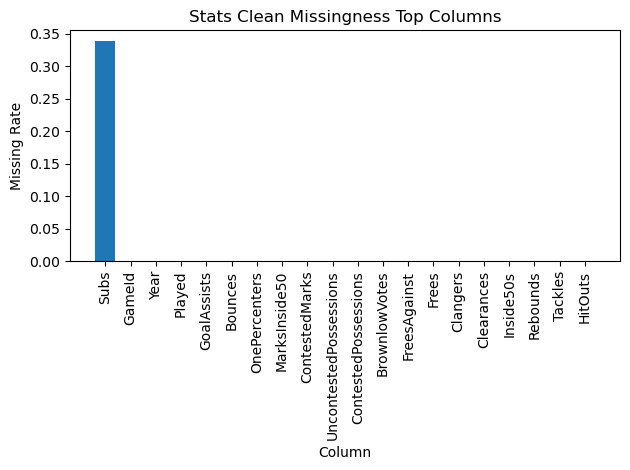

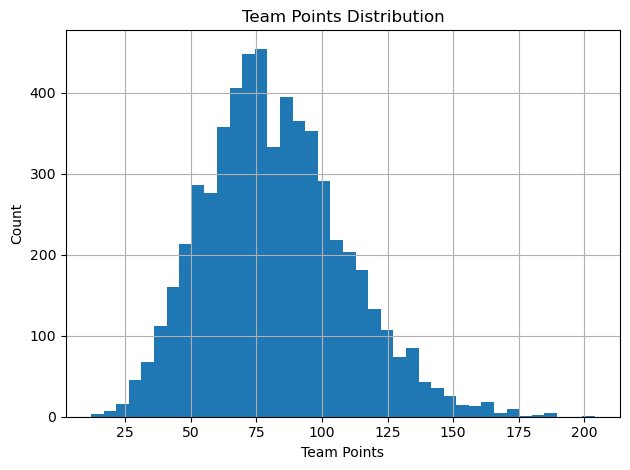

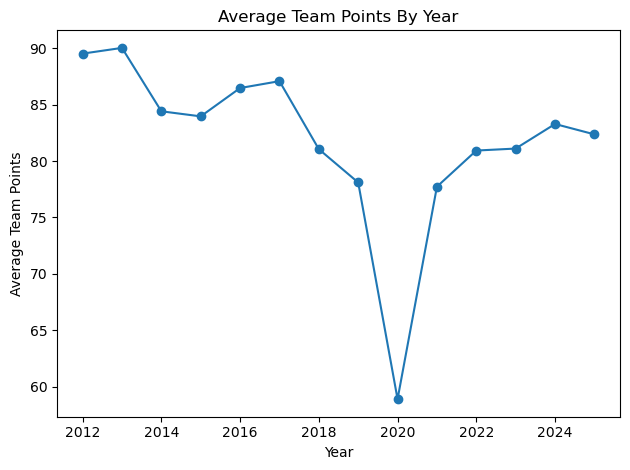

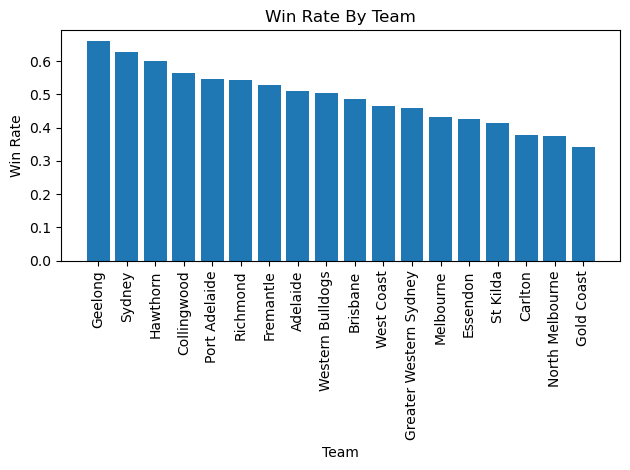

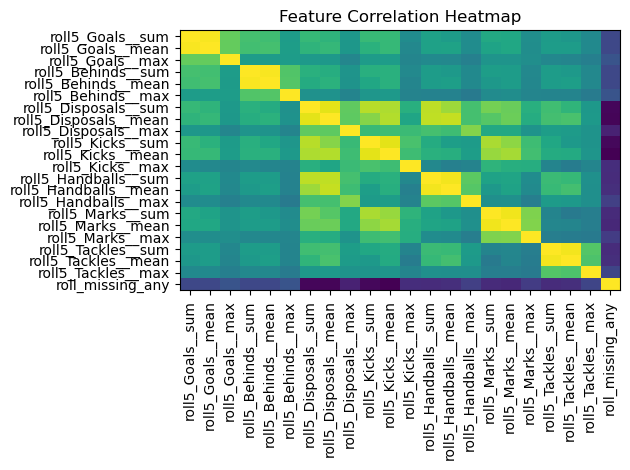

In [36]:
def main_stats_visuals(stats_clean_final: pd.DataFrame, team_game: pd.DataFrame, model_df: pd.DataFrame) -> None:
    plot_missingness(stats_clean_final, "Stats Clean Missingness Top Columns", top_n=20)
    plot_team_points(team_game)
    plot_points_by_year(team_game)
    plot_win_rate_by_team(team_game)
    plot_feature_correlation(model_df, max_features=25)

main_stats_visuals(stats_clean_final, team_game, model_df)

# Block 29 - Save Processed Stats Outputs

In [37]:
from pathlib import Path

def save_stats_outputs(
    stats_clean_final: pd.DataFrame,
    model_df: pd.DataFrame,
    out_dir: str = "data/processed"
) -> None:
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    stats_clean_final.to_parquet(out / "stats_clean_final.parquet", index=False)
    model_df.to_parquet(out / "team_game_model_df.parquet", index=False)

    print("Saved", out / "stats_clean_final.parquet", flush=True)
    print("Saved", out / "team_game_model_df.parquet", flush=True)

save_stats_outputs(stats_clean_final, model_df)

Saved data/processed/stats_clean_final.parquet
Saved data/processed/team_game_model_df.parquet
